In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, BatchNormalization
import matplotlib.pyplot as plt
from azure.storage.blob import BlobServiceClient, generate_blob_sas, BlobSasPermissions
from datetime import datetime, timedelta
import urllib.request
from PIL import Image
import numpy as np
from azureml.core import *

import os


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [18]:
x_train,x_test = load_dataset()

In [24]:
x_train = x_train.astype("float32") / 255.0
x_train = tf.expand_dims(x_train, -1)
x_test = x_test.astype("float32") / 255.0
x_test = tf.expand_dims(x_train, -1)

In [25]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [26]:
latent_dim = 200

encoder_inputs = keras.Input(shape=(50 , 50, 1))
x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(200, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 25, 25, 512)  5120        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 25, 25, 512)  2048       ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 13, 13, 128)  589952      ['batch_normalization[0][0]

In [28]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Dense(25 * 25 * latent_dim, activation="relu")(latent_inputs)
x = layers.Reshape((25, 25, latent_dim))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_2 (Dense)             (None, 125000)            25125000  
                                                                 
 reshape (Reshape)           (None, 25, 25, 200)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 50, 50, 128)      230528    
 nspose)                                                         
                                                                 
 batch_normalization_5 (Batc  (None, 50, 50, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 50, 50, 128)      1475

In [29]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq="2")

In [ ]:
x_train, x_test = x_train,x_test

vae = VAE(encoder, decoder)

opt = keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=opt,loss='sparse_categorical_crossentropy')

vae.fit(x_train, epochs=100, batch_size=16)

In [36]:
x_test_encoded = encoder.predict(x_test, batch_size=16)

625/625 [==============================] - 1s 2ms/step


In [39]:
x_decoded = vae.decoder.predict(x_test_encoded[0])

313/313 [==============================] - 6s 19ms/step


In [40]:
x_decoded.shape

(10000, 50, 50, 1)

In [41]:
import matplotlib.pyplot as plt

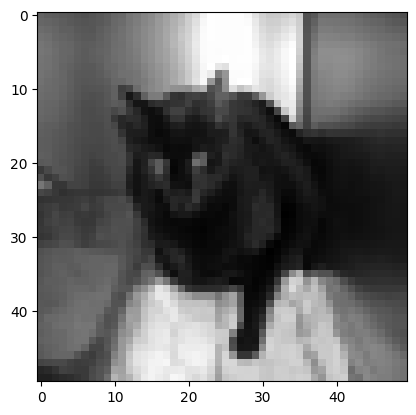

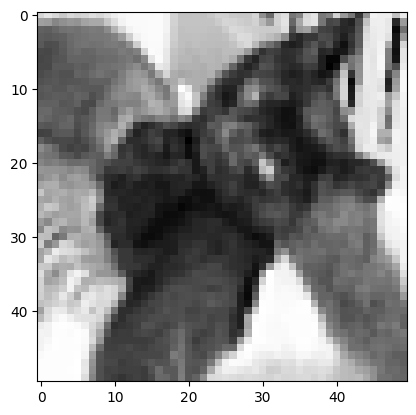

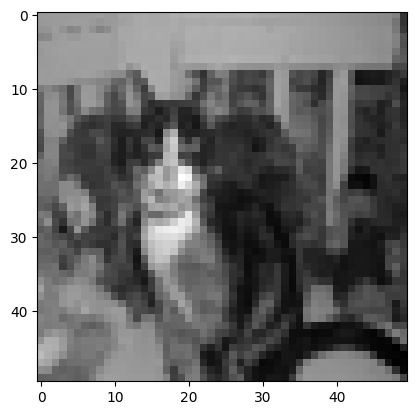

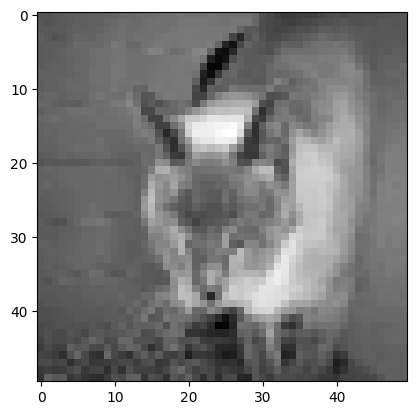

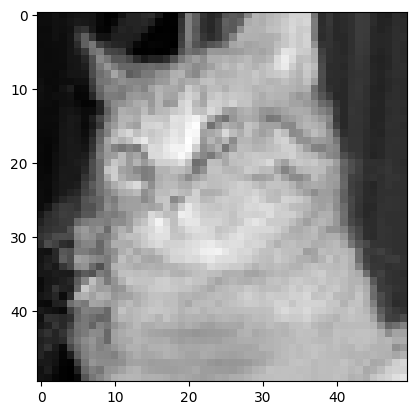

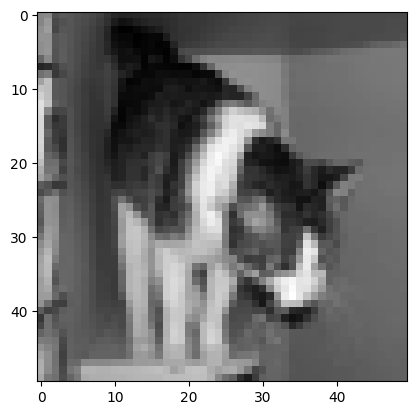

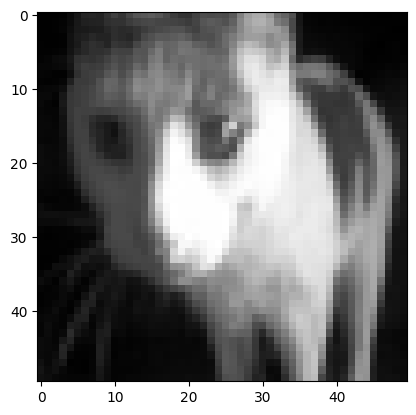

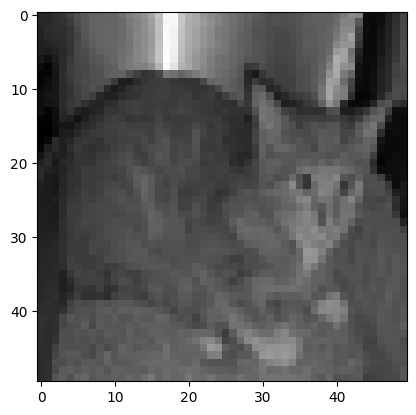

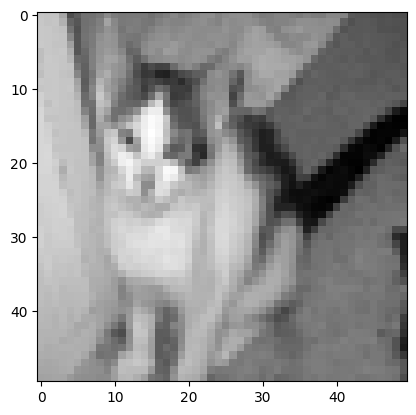

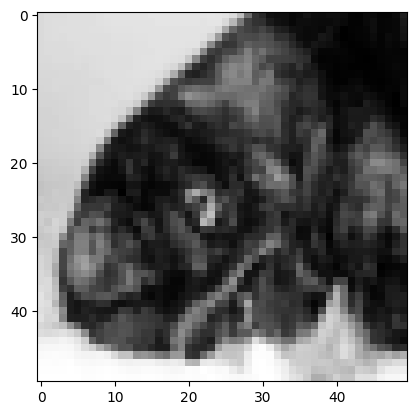

In [48]:
for i in range(50,60):
    plt.imshow(x_test2[i],cmap="gray")
    plt.show()

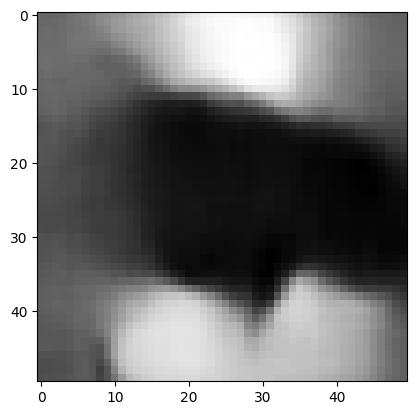

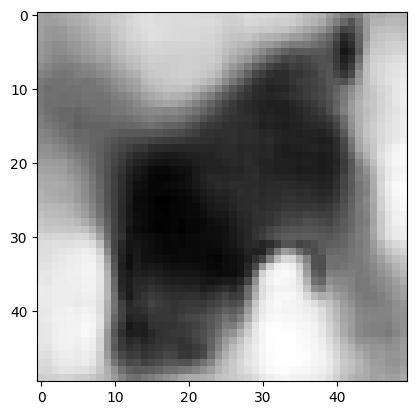

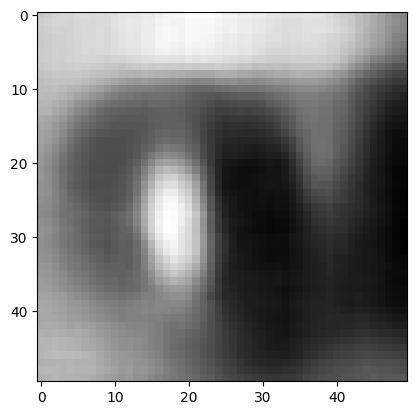

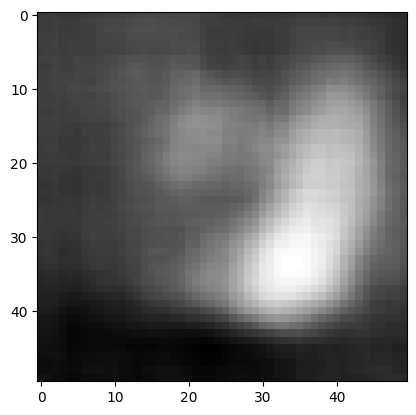

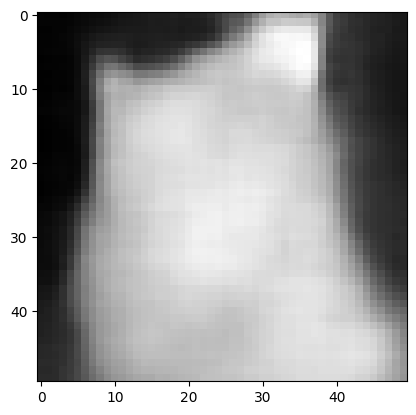

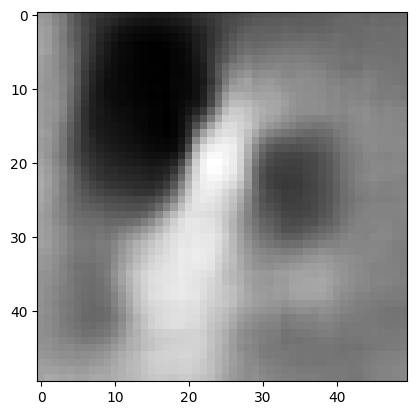

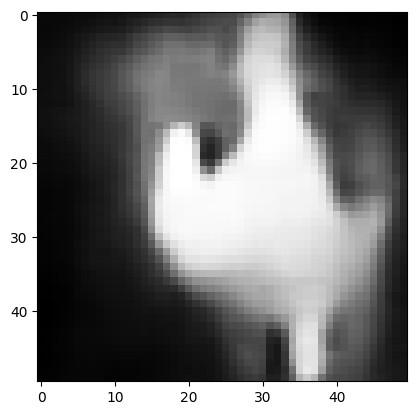

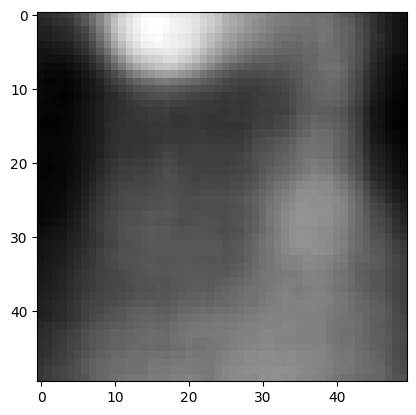

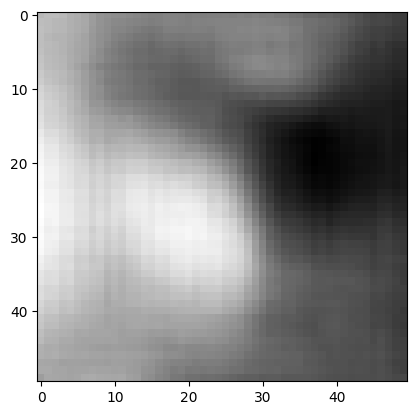

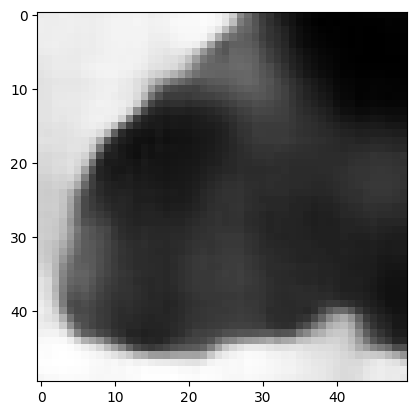

In [49]:
for i in range(50,60):
    plt.imshow(x_decoded[i],cmap="gray")
    plt.show()